Control and State estimation of unstable system

In [334]:
import numpy as np
import matplotlib.pyplot as plt
import control

In [335]:
# A = np.matrix('0 1; 2 -1')
A = np.matrix('0 3; -1 -1.3')
B = np.matrix("1; 0")
C = np.matrix("1 0")
D = 0
sys = control.ss(A, B, C, D)  # Creating the state space object
print(A)

[[ 0.   3. ]
 [-1.  -1.3]]


In order to determine the stability of the system, its eigen values are determined by evaluating the following

$$
det(\mathbf{A} - \lambda\mathbf{I}) =
det \begin{bmatrix}
0 - \lambda & 1 \\
2 & -1 -\lambda
\end{bmatrix}
= 0
$$

$$
(-\lambda)(-1-\lambda) - 2 = 0
$$

$$
 \lambda^2 + \lambda - 2 = 0
$$

$$
\lambda = -2  \vee \lambda = 1
$$

As can be seen, the system has the positive eigen value $\lambda=1$, thus the system has an unstable pole

In [336]:
# Getting eigenvalues with np.linalg
eig = np.linalg.eigvals(A)
print(f"The eigenvalues to the system matrix A is: k_1={eig[0]}, and k_2={eig[1]}")

The eigenvalues to the system matrix A is: k_1=(-0.6499999999999999+1.605459435800232j), and k_2=(-0.6499999999999999-1.605459435800232j)


Plot the step response and PZ-map of the system

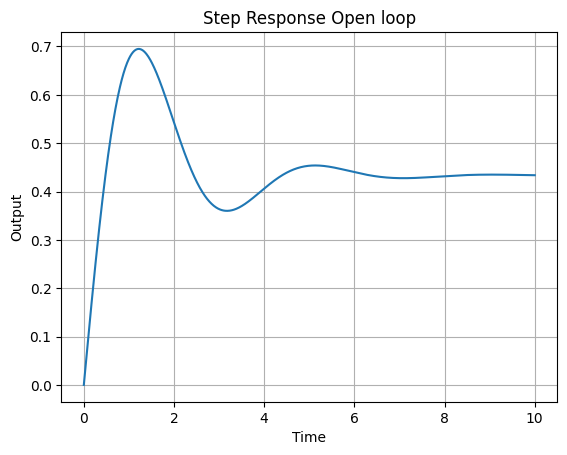

In [337]:
t = np.linspace(0, 10, 1000)
u = np.ones_like(t)

t, y = control.step_response(sys, T=t, X0=[0,0], input=u)

# Plot the response
plt.plot(t, y)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Step Response Open loop')
plt.grid(True)
plt.show()

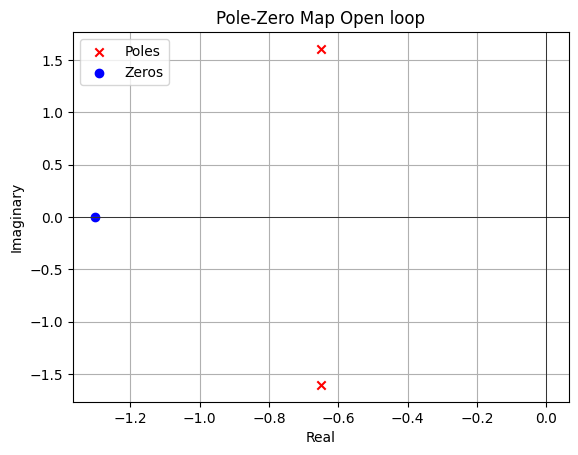

In [338]:
poles = control.poles(sys)
zeros = control.zeros(sys)

plt.figure()
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.scatter(np.real(poles), np.imag(poles), marker='x', color='red', label='Poles')
plt.scatter(np.real(zeros), np.imag(zeros), marker='o', color='blue', label='Zeros')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Pole-Zero Map Open loop')
plt.legend()
plt.grid(True)
plt.show()

Make the system stable by introducing control in order to move all the system poles to the left plane.
First check that the system is controllable.

In [339]:
# Check system controllability
C_ctrb = control.ctrb(A, B)
C_rank = np.linalg.matrix_rank(C_ctrb)

if C_rank == A.shape[0]:
    print("The system is controllable.")
else:
    print("The system is not controllable.")

The system is controllable.


Now that the system has been verified to be controllable, the poles are placed by utilizing a linear quadratic regulator (LQR)

In [340]:
Q = np.matrix([
    [10, 0],
    [0, 0.1]
])

R = np.matrix([[1]])  # Must be matrix get error if not, "normal" value works for control.lqr()

# Solve the algebraic Riccati equation
R_ric, _, _ = control.care(A, B, Q, R)
X = R_ric
#Compute the LQR gain matrix
K = np.linalg.inv(R) @ B.T @ X
print(K)

K, _, _ = control.lqr(A, B, Q, R)  # Just to verify the gain matrix is calculated with the lqr function
print(K)

[[2.68598031 1.39275489]]
[[2.68598031 1.39275489]]


By introducing full state feedback, the close loop system matrix becomes

$$
\mathbf{A_{cl}} = \mathbf{A} - \mathbf{BK}
$$

In [341]:
A_cl = A - B@K
sys_cl = control.ss(A_cl, B, C, D)

# Validate that the system has been made stable by introducing the input on the system from the state feeback
eig = np.linalg.eigvals(A_cl)
print(f"The eigenvalues to the system matrix A is: k_1={round(eig[0],2)}, and k_2={round(eig[1],2)}")


The eigenvalues to the system matrix A is: k_1=(-1.99+1.06j), and k_2=(-1.99-1.06j)


C:\Users\Sondre\AppData\Local\Temp\ipykernel_25128\2857754082.py:6: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  print(f"The eigenvalues to the system matrix A is: k_1={round(eig[0],2)}, and k_2={round(eig[1],2)}")


Can see that the system has become stable, since now all the poles are on the left plane. Next the
step response of the closed loop system is checked.

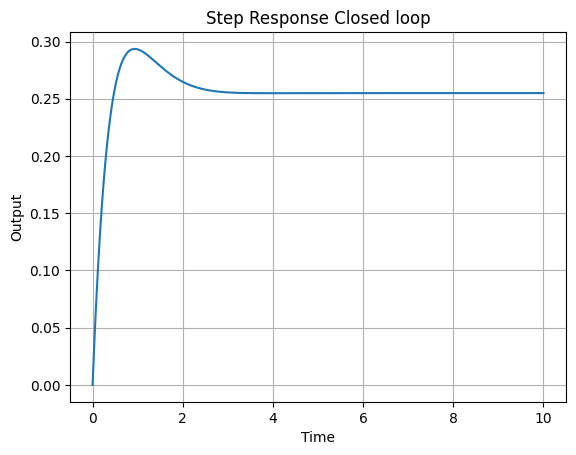

In [342]:
t = np.linspace(0, 10, 1000)
u = np.ones_like(t)

t, y = control.step_response(sys_cl, T=t, X0=[0,0], input=u)

# Plot the response
plt.plot(t, y)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Step Response Closed loop')
plt.grid(True)
plt.show()

From the step response it can be seen that the system does not reach the reference value of 1. In order to solve this, a prefilter is computed to ensure steady-state accuracy. This is done by computing the following

$$
\mathbf{V} = \mathbf{(C(BK-A)^{-1}B)^{-1}}
$$

In [343]:

t1 = np.linalg.inv(B@K-A)  # Calculate (B*K-A)^(-1)
t2 = C@t1  # Calculate C*(B*K-A)^(-1)
t3 = np.linalg.inv(t2@B) # Calculate (C*(B*K-A)^(-1)*B)^(-1)
V = t3
print(f"V = {round(V[0,0],3)}")

V = 3.922


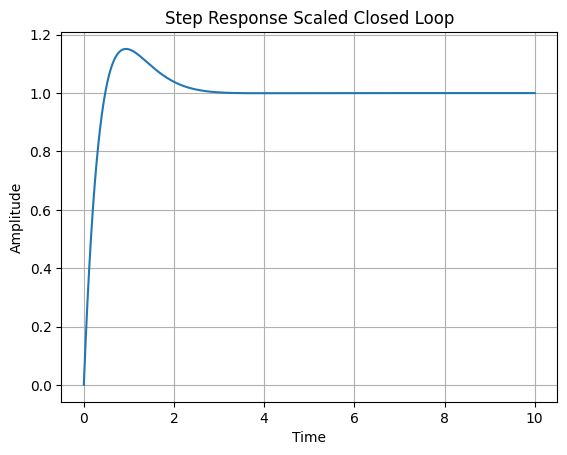

In [344]:
t, y = control.step_response(V*sys_cl, T=t)

plt.plot(t, y)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Step Response Scaled Closed Loop')
plt.grid(True)
plt.show()

### Observer ###

Now, lets assume that the model of the system is not completely the same as the actual plant

In [345]:
# Check system observability
O_obsv = control.obsv(A, C)
O_rank = np.linalg.matrix_rank(O_obsv)

if O_rank == A.shape[0]:
    print("The system is observable.")
else:
    print("The system is not observable. Cannot design observer.")

The system is observable.


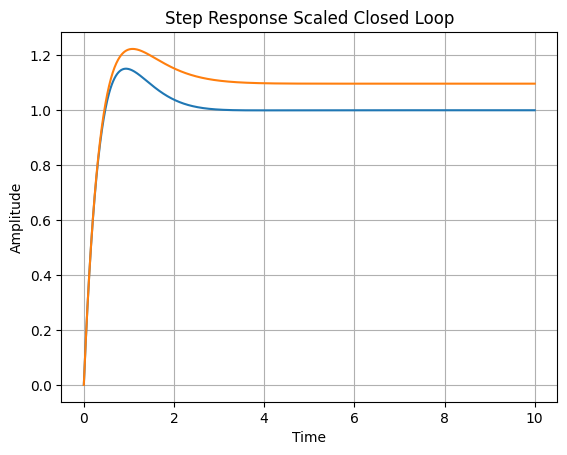

In [346]:
A_m = 0.85*A
A_m_cl = A_m - B@K
sys_m = control.ss(A_m_cl, B*V, C, D)

t, y1 = control.step_response(sys_m, T=t)

plt.plot(t, y)
plt.plot(t, y1)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Step Response Scaled Closed Loop')
plt.grid(True)
plt.show()


Can see that the step response that the model think is appropriate has steady state error. Correct this by modeling an observer to estimate the state error

In [347]:
# Get the fastest pole of System
fast_pole = max(abs(control.poles(sys_cl)))
print(f"Fastest system pole: {-fast_pole}")
observer_poles = [-4*fast_pole, -4*fast_pole-5]  # Multiplying with a negative number since abs from fastest pole give unstable pole
L = control.place(A.T, C.T, observer_poles)  # .T transposes the matrices
print(f"Observer feedback gains, L=[{round(L[0,0],2)}, {round(L[0,1], 2)}]")

Fastest system pole: -2.2581008643532257
Observer feedback gains, L=[21.76, 31.82]


In [348]:
Aobs = A-L.T@C  # @ sign means matrix multiplication in Python
Bobs = np.concatenate((B, L.T), axis=1)  # Merge similar to C = [A B]
Cobs = C
Dobs = D
sys_obs = control.ss(Aobs, Bobs, Cobs, Dobs)

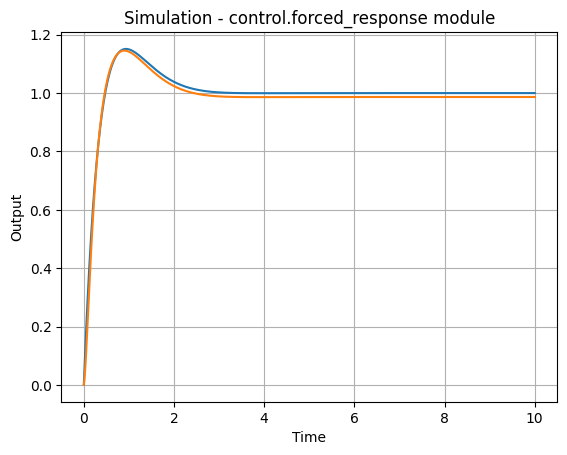

In [349]:
t_sim = np.linspace(0, 10, 1000)
u = np.ones_like(t_sim)

t_cl, y_cl = control.forced_response(V*sys_cl, T=t_sim, X0=[0,0], U=u)
u_obs = np.vstack((u, y_cl))
t_obs, y_obs = control.forced_response(sys_obs, T=t_sim, X0=[0,0], U=u_obs)

# Plot the response
plt.plot(t_sim, y_cl)
plt.plot(t_sim, y_obs[0])
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Simulation - control.forced_response module')
plt.grid(True)
plt.show()